In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations


from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
seed = 42
max_training_epochs = 1000
loss = 'emd'
experiment_name = 'three_fc_dec_longer' + str(n_pc_samples) +  'pts_' + loss

In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
train_dir = osp.join(top_data_dir, 'OUT/models/nips/denoising_ae/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/denoising_ae/three_fc_dec_longer2048pts_emd'

In [6]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

In [8]:
# np.random.seed(seed)
# tf.set_random_seed(seed)

# train_data_, val_data_, test_data_, r_indices = pio.train_validate_test_split(
#                                                             [full_pclouds, full_model_names],
#                                                             train_perc=0.85,
#                                                             validate_perc=0.05,
#                                                             test_perc=0.1,
#                                                             seed=seed)

# model_ids = np.vstack((full_model_names, full_syn_ids)).T

# if first_time_running:
#     write_model_ids_of_datasets(train_dir, model_ids, r_indices)

# train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
# val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
# test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])


model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=model_unames)

In [ ]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_pc_samples, 3]

    decoder_args = {'layer_sizes': [1024, 2048, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                denoising = True,
                gauss_augment = {'mu': 0, 'sigma': 0.005}, 
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.0005,
                z_rotate = True,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

In [ ]:
if do_training:
    training_stats = []
    training_stats.append(ae.train(train_data, conf))    
    with open(osp.join(conf.train_dir, 'train_stats.txt'), 'a') as fout:
        np.savetxt(fout, np.array(training_stats)[0])

('Epoch:', '0001', 'training time (minutes)=', '9.1873', 'loss=', '245.816760897')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/denoising_ae/three_fc_dec_longer2048pts_emd/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '9.2051', 'loss=', '200.083518902')
('Epoch:', '0003', 'training time (minutes)=', '9.2895', 'loss=', '189.363995635')
('Epoch:', '0004', 'training time (minutes)=', '9.2677', 'loss=', '181.225793779')
('Epoch:', '0005', 'training time (minutes)=', '9.2499', 'loss=', '176.792900218')
('Epoch:', '0006', 'training time (minutes)=', '9.4341', 'loss=', '172.597360272')
('Epoch:', '0007', 'training time (minutes)=', '9.3432', 'loss=', '170.213821836')
('Epoch:', '0008', 'training time (minutes)=', '9.4276', 'loss=', '166.356497336')
('Epoch:', '0009', 'training time (minutes)=', '9.4289', 'loss=', '165.020651289')
('Epoch:', '0010', 'training time (minutes)=', '9.3986', 'lo

In [ ]:
if load_model:
    saved_epochs = read_saved_epochs(conf.train_dir)
    last_epoch = saved_epochs[-1]
    ae.restore_model(conf.train_dir, last_epoch, verbose=True)

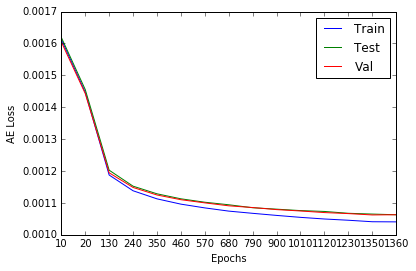

In [11]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, val_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')  
    plot_train_val_test_curves(stats, top_save_dir, has_validation=True, best_epoch=None, show=True)    
    
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=400)
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=400)